In [1]:
import sys
sys.path.append("../")

In [2]:
import colorterms

In [3]:
colorterms.load_catalogs(path='../catalogs')

In [4]:
lbda = colorterms.CATALOGS['gunnstryker'][1]['lbda']
flux = colorterms.CATALOGS['gunnstryker'][1]['flux']

In [5]:
spec = colorterms.Spectrum(lbda, flux, fpath="../filtersets")

INFO: Loading megacam filter set
 - loading g
 - loading i
 - loading i2
 - loading r
 - loading u
 - loading z
INFO: Loading sdss filter set
 - loading g
 - loading i
 - loading r
 - loading u
 - loading z


In [9]:
%matplotlib inline
import pylab as plt

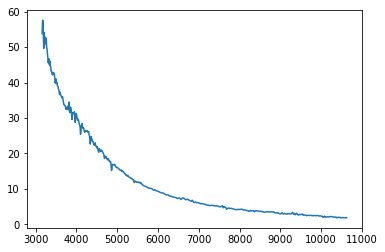

In [10]:
plt.plot(lbda, flux)

In [13]:
spec.mag(syst='megacam', filt='g')

(-32.44469612387319, None)